# Faraday Complexity: A How to Guide

In this Jupyter notebook, we'll give an overview of how our scripts work and how to utilize them for constructing and training neural networks to identity complex Faraday sources.

## Generating data with possum and simulate

The *possum* and *simulate* classes are used to generate data. By itself, the functions with possum are more focused on creating a spectrum for a single source, while the inherited functions from simulate allow us to generate a large number of sources with a few function calls.

Let's begin by importing the possum class. Since possum inherits simulate, it will automatically load as well.

In [1]:
from possum import *

There are a few frequency bands that are already part of the possum class: ASKAP 12 (700 - 1300 MHz, 1500 - 1800 MHz), ASKAP 36 (1130 - 1430 MHZ), and the Westerbork Synthesis Radio Telescope (WRST, 310 - 380 MHz). These can be created by calling the functions

    _createASKAP12()
    _createASKAP36()
    _createWSRT()
    
which store the frequencies (in Hz) in the variable 

    nu_
    
If you need another frequency range, the function *_createFrequency* will be of good use. It takes four parameters: the minimum (*numin*) and maximum (*numax*) frequencies, as well as the number of channels (*nchan*) and returns the frequencies. If you would like to store the results in *self.nu_*, then set the fourth parameter "store" to True:
    
    _createFrequency(numin=700., numax=1800., nchan=100., store=True)
    
As an example of how the functions within this class work, we can create the ASKAP 12 coverage by running the following commands and verify that our range is over the proper frequency range:

In [2]:
spec = possum()
spec._createASKAP12()

print('Min Frequency (Hz): {:e}'.format(spec.nu_.min()))
print('Max Frequency (Hz): {:e}'.format(spec.nu_.max()))

Min Frequency (Hz): 7.000000e+08
Max Frequency (Hz): 1.800000e+09


### Polarization Spectra

Simple and complex polarization spectra can both be created using the *_createNspec* function, which takes in the parameters *flux*, *depth*, *chi*, and *sigma*, where flux is the strength of the source, depth is the Faraday depth, chi is the phase, and sigma is the noise. The function call is as follows

    _createNspec(flux, depth, chi, sigma)
    
For complex sources, one passes in the flux, depth, and chi as an array or list. The polarization spectra is stored in the variable

    polarization_

As an illustration, let's create a polarization spectrum of a simple and complex source and plot the real ($Q$) and imaginary ($U$) components. We'll create a custom frequency range to illustrate the *_createFrequency* function.

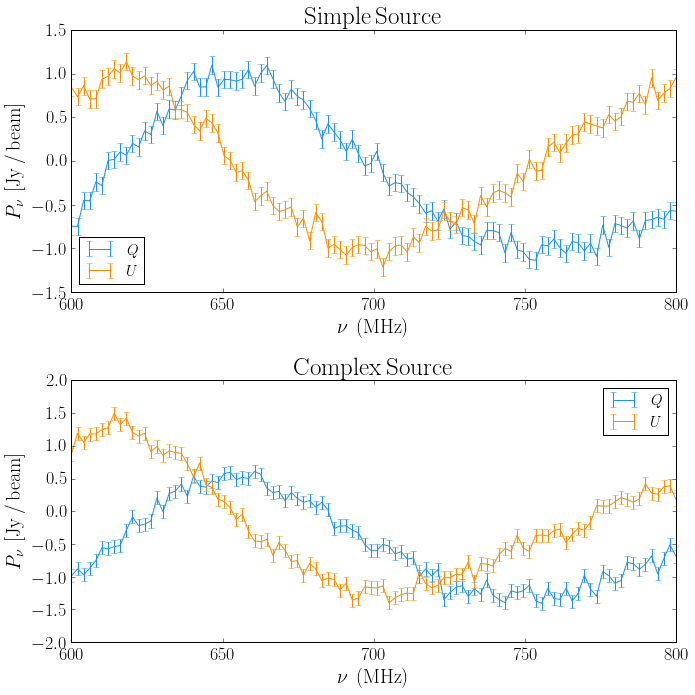

In [3]:
spec = possum()
spec._createFrequency(600, 800, 100, store=True)

# ==========================================================
# Convert frequency to MHz for plotting purposes
# ==========================================================
nu = spec.nu_ / 1e6


plt.figure(1, figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=18)

# ==========================================================
# Plot the polarization spectrum of the simple source
# ==========================================================
flux1 = 1   
depth1 = 30
chi1 = 0
sig = 0.1

spec._createNspec(flux1, depth1, chi1, sig)

plt.subplot(2,1,1)
plt.errorbar(nu, spec.polarization_.real, yerr=sig, label=r'$Q$', color='dodgerblue')
plt.errorbar(nu, spec.polarization_.imag, yerr=sig, label=r'$U$', color='darkorange')
plt.xlabel(r'$\nu \: \left(\mathrm{MHz}\right)$', fontsize=20)
plt.ylabel(r'$P_\mathrm{\nu} \: \left[\rm Jy \, / \, beam\right]$', fontsize=20)
plt.title(r'$\rm Simple \, Source$', fontsize=25)
plt.tight_layout()
plt.legend(loc='best', fontsize=15)

# ==========================================================
# Plot the polarization spectrum of the complex source
# ==========================================================

flux2 = [1, 0.5]
depth2 = [30, -10]
chi2 = [0, 0.5]
sig = 0.1

spec._createNspec(flux2, depth2, chi2, sig)

plt.subplot(2,1,2)
plt.errorbar(nu, spec.polarization_.real, yerr=sig, label=r'$Q$', color='dodgerblue')
plt.errorbar(nu, spec.polarization_.imag, yerr=sig, label=r'$U$', color='darkorange')
plt.xlabel(r'$\nu \: \left(\mathrm{MHz}\right)$', fontsize=20)
plt.ylabel(r'$P_\mathrm{\nu} \: \left[\rm Jy \, / \, beam\right]$', fontsize=20)
plt.title(r'$\rm Complex \, Source$', fontsize=25)
plt.tight_layout()
plt.legend(loc='best', fontsize=15)
plt.show()

### Faraday Rotation

The Faraday rotation spectra can be created using the function *_createFaradaySpectrum*, which takes in two parameters: the minimum (*philo*) and maximum (*phihi*) Faraday depths:

    _createFaradaySpectrum(philo, phihi)
    
and stores the faraday depth $\phi$ and the source spectrum in the following variables:

    phi_
    faraday_
    
In the script below, we generate the Faraday spectrum of the polarization spectrum show above and plot the real and imaginary components, along with their magnitude. The faraday depths for the two sources are indicated by vertical dashed lines.

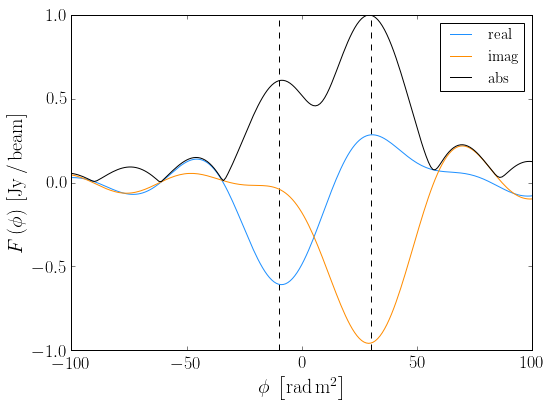

In [4]:
spec._createFaradaySpectrum(-100, 100)

plt.figure(1, figsize=(8, 6))

# ==================================================
# Plot the real, imag, and abs value
# ==================================================
plt.plot(spec.phi_, spec.faraday_.real, label=r'$\rm real$', color='dodgerblue')
plt.plot(spec.phi_, spec.faraday_.imag, label=r'$\rm imag$', color='darkorange')
plt.plot(spec.phi_, np.abs(spec.faraday_), label=r'$\rm abs$', color='black')

# ==================================================
# Add the two faraday depths to the plot
# ==================================================
plt.vlines(x=depth2, ymin=-1, ymax=1, linestyle='dashed')

# ==================================================
# Add labels and display
# ==================================================
plt.xlabel(r'$\phi \: \left[\rm rad \, m^{2}\right]$', fontsize=20)
plt.ylabel(r'$F\left(\phi\right) \: \left[\mathrm{Jy \, / \, beam}\right]$', fontsize=20)
plt.legend(loc='best', fontsize=15)
plt.tight_layout()
plt.show()

### Generating a Large Number of Spectra

That's everything you need to know to be able to generate a simulated polarization and faraday spectra using the possum class. To generate a large number of sources, we turn ourselves to the functions inside the simulate class.



In [8]:
spec = possum()
spec._generateParams(5)
print(spec.label_)

[0 1 1 0 1]


In [5]:
spec = possum()
plt.figure(figsize=(8,6))
spec._simulateNspec(N=4, pcomplex=0.5, width=250)

1 of 4


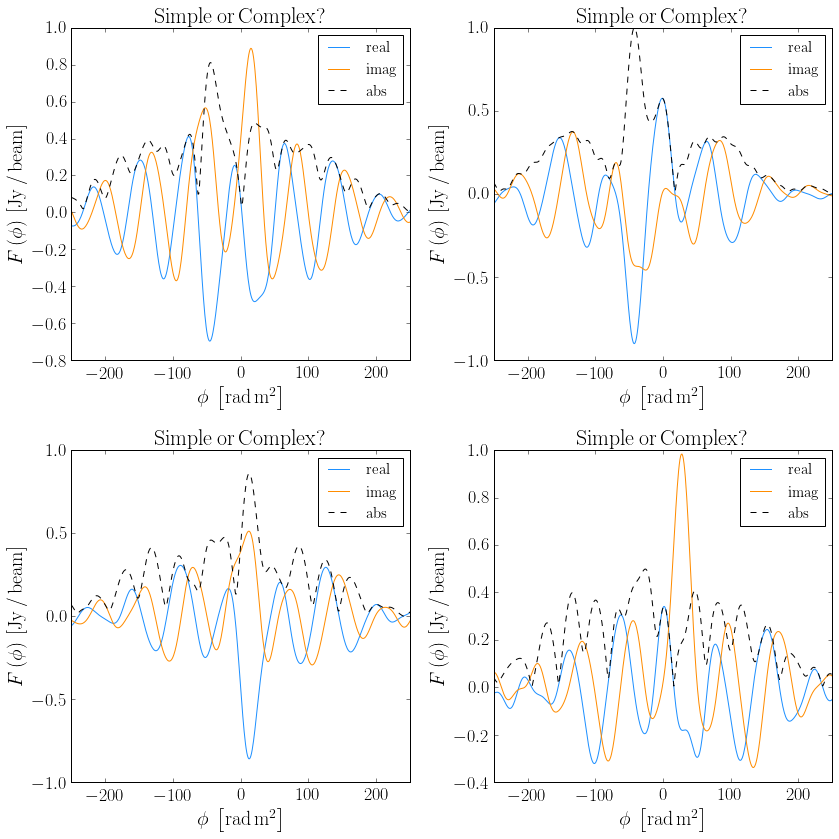

In [6]:
plt.figure(figsize=(12,12))

for s, _ in enumerate(spec.label_):
    plt.subplot(2,2,s+1)
    plt.plot(spec.phi_, spec.X_[s,:,0], color='dodgerblue', label=r'$\rm real$')
    plt.plot(spec.phi_, spec.X_[s,:,1], color='darkorange', label=r'$\rm imag$')
    plt.plot(spec.phi_, np.abs(spec.X_[s,:,0] + 1j*spec.X_[1,:,1]), 'k--', label=r'$\rm abs$')

    plt.xlim(-250, 250)

    plt.xlabel(r'$\phi \: \left[\rm rad \, m^{2}\right]$', fontsize=20)
    plt.ylabel(r'$F\left(\phi\right) \: \left[\mathrm{Jy \, / \, beam}\right]$', fontsize=20)
    plt.title(r'$\rm Simple \, or \, Complex?$', fontsize=22)
    plt.legend(loc='best', fontsize=15)
    
plt.tight_layout()
plt.show()

Answers:

In [7]:
print(spec.label_)

[1 1 0 0]


## Building CNNs with inception